# Expense Tracker with AWS Textract

### Imports

In [61]:
import boto3
import io
from io import BytesIO
import sys
from time import gmtime, strftime
import re
import time
from string import digits
import json
from dateutil import parser
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import imshow
import matplotlib
matplotlib.style.use('ggplot')

from PIL import Image, ImageDraw, ImageFont

### Helper Function

In [34]:
def process_receipt(document, 
                    bucket = 'textract-expense-tracker', 
                    display=False, upload=True, printout=False):
                      
    s3_object = boto3.resource('s3').Object(bucket, document)
    s3_response = s3_object.get()
    stream = io.BytesIO(s3_response['Body'].read())
    bucket_location = boto3.client('s3').get_bucket_location(Bucket=bucket)
    
    ######################################
    #INVOKING TEXTRACT
    ######################################
    text = boto3.client('textract')
    image_binary = stream.getvalue()
    response = text.detect_document_text(Document={'Bytes': image_binary})

    dates = []
    totals = []
    
    for i, block in enumerate(response["Blocks"]):
        if block["BlockType"] == "LINE":

            date = re.search("[0-3]?[0-9]/[0-3]?[0-9]/(?:[0-9]{2})?[0-9]{2}", block["Text"])
            total = re.search("Total|TOTAL", block["Text"])

            if date is not None: 
                dates.append(date.group())
            if total is not None: 
                total = ''.join(c for c in response["Blocks"][i+1]["Text"] if c in digits+"."+",")
                if total == '':
                    total = ''.join(c for c in response["Blocks"][i-1]["Text"] if c in digits+"."+",")
                totals.append(total.replace(",", "."))

    date = list(set(dates))[0]
    dt = parser.parse(date)
    date = dt.strftime("%Y-%m-%d")
    amount = list(set(totals))[0]
    
    if printout:
         print(f"Document: {document}; Date: {date}; Amount: {amount}")
            
    if display: 
        image = Image.open(stream)
        fig, ax = plt.subplots(figsize=(5,10))
        ax.imshow(image)
        plt.show()
    
    ######################################
    #SAVING JSON WITH SENTIMENT TO S3
    ######################################
    content = {            
            'receipt' : f"https://{bucket}.s3-{bucket_location['LocationConstraint']}.amazonaws.com/{document}",
            'submitted_on' : strftime("%Y-%m-%d %H:%M:%S GMT", gmtime()),
            'date' : date,
            'amount' : float(amount)
    }
    
    if upload: 
        boto3.client('s3').put_object(Body=json.dumps(content), Bucket=bucket, Key="textracted/"+document.replace("jpg", "json"));
    
    return

### Running on one receipt

Document: receipt4.jpg; Date: 2017-05-12; Amount: 2.64


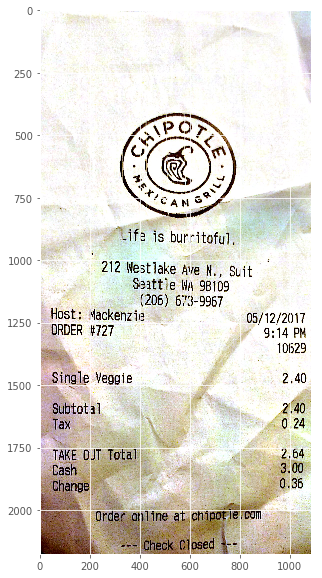

In [67]:
process_receipt('receipt4.jpg', display=True, upload=False, printout=True)

### Running on all receipts and uploading JSONs to S3

Document: receipt1.jpg; Date: 2017-05-10; Amount: 7.60


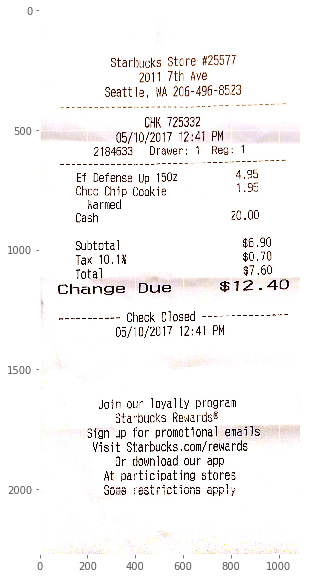

Document: receipt10.jpg; Date: 2017-05-10; Amount: 49.16
Document: receipt11.jpg; Date: 2017-05-10; Amount: 6.83
Document: receipt12.jpg; Date: 2017-05-10; Amount: 7.60
Document: receipt13.jpg; Date: 2017-05-09; Amount: 8.15
Document: receipt14.jpg; Date: 2017-05-08; Amount: 18.72


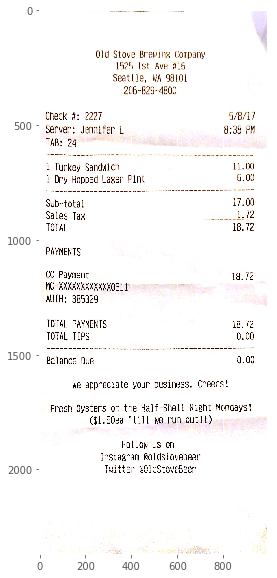

Document: receipt15.jpg; Date: 2017-05-08; Amount: 2.15
Document: receipt16.jpg; Date: 2017-05-08; Amount: 20.64
Document: receipt17.jpg; Date: 2017-05-08; Amount: 2.48
Document: receipt18.jpg; Date: 2017-05-08; Amount: 7.54
Document: receipt19.jpg; Date: 2017-05-07; Amount: 23.13


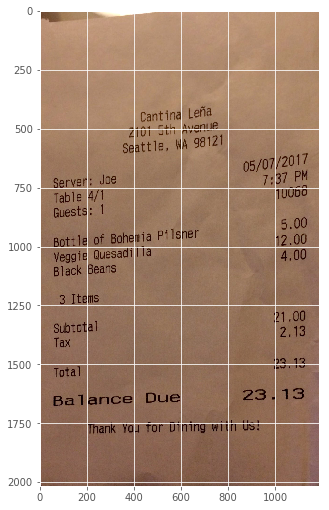

Document: receipt2.jpg; Date: 2017-05-13; Amount: 2.15
Document: receipt20.jpg; Date: 2017-08-11; Amount: 4.30
Document: receipt22.jpg; Date: 2017-05-14; Amount: 4.50
Document: receipt23.jpg; Date: 2017-05-13; Amount: 2.15
Document: receipt24.jpg; Date: 2017-05-13; Amount: 3.25


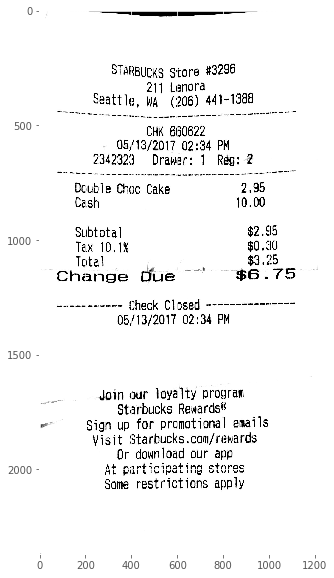

Document: receipt3.jpg; Date: 2017-05-12; Amount: 7.38
Document: receipt4.jpg; Date: 2017-05-12; Amount: 2.64
Document: receipt5.jpg; Date: 2017-05-12; Amount: 92.48
Document: receipt6.jpg; Date: 2017-05-12; Amount: 2.19
Document: receipt7.jpg; Date: 2017-05-11; Amount: 8.81


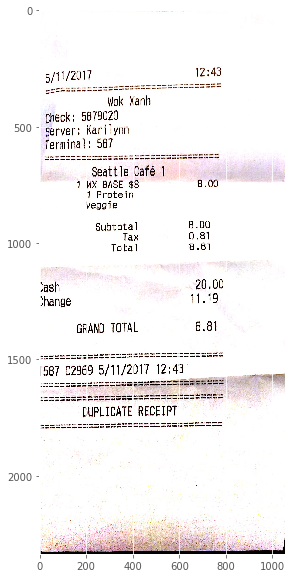

Document: receipt8.jpg; Date: 2017-05-11; Amount: 6.87
Document: receipt9.jpg; Date: 2017-05-10; Amount: 15.96


In [68]:
s3 = boto3.resource('s3')
bucket = s3.Bucket('textract-expense-tracker')

for i, receipt in enumerate(bucket.objects.filter()):
    if ".jpg" in receipt.key:
        if i % 5 == 0:
            process_receipt(receipt.key, printout=True, display=True)
        else:
            process_receipt(receipt.key, printout=True)
        time.sleep(2)

### Checking JSON output in S3

In [17]:
s3 = boto3.resource('s3')
content_object = s3.Object('textract-expense-tracker', 'textracted/receipt7.json')
file_content = content_object.get()['Body'].read().decode('utf-8')
json_content = json.loads(file_content)
print(json.dumps(json_content, indent=2))

{
  "receipt": "https://textract-expense-tracker.s3-eu-west-1.amazonaws.com/receipt7.jpg",
  "submitted_on": "2019-06-17 21:20:16 GMT",
  "date": "2017-05-11",
  "amount": 8.81
}


### Plotting expenses over time

In [49]:
jsons = []
for extract in bucket.objects.filter():
    if ".json" in extract.key:
        content_object = s3.Object(extract.bucket_name, extract.key)
        file_content = content_object.get()['Body'].read().decode('utf-8')
        jsons.append(json.loads(file_content))

In [65]:
expenses = pd.concat([pd.DataFrame(j, index=[0]) for j in jsons], ignore_index=True)
expenses

,receipt,submitted_on,date,amount
0,https://textract-expense-tracker.s3-eu-west-1....,2019-06-17 21:18:41 GMT,2017-05-10,7.60
1,https://textract-expense-tracker.s3-eu-west-1....,2019-06-17 21:18:45 GMT,2017-05-10,49.16
2,https://textract-expense-tracker.s3-eu-west-1....,2019-06-17 21:18:50 GMT,2017-05-10,6.83
3,https://textract-expense-tracker.s3-eu-west-1....,2019-06-17 21:18:54 GMT,2017-05-10,7.60
4,https://textract-expense-tracker.s3-eu-west-1....,2019-06-17 21:18:59 GMT,2017-05-09,8.15
5,https://textract-expense-tracker.s3-eu-west-1....,2019-06-17 21:19:04 GMT,2017-05-08,18.72
6,https://textract-expense-tracker.s3-eu-west-1....,2019-06-17 21:19:09 GMT,2017-05-08,2.15
7,https://textract-expense-tracker.s3-eu-west-1....,2019-06-17 21:19:13 GMT,2017-05-08,20.64
8,https://textract-expense-tracker.s3-eu-west-1....,2019-06-17 21:19:18 GMT,2017-05-08,2.48
9,https://textract-expense-tracker.s3-eu-west-1....,2019-06-17 21:19:23 GMT,2017-05-08,7.54


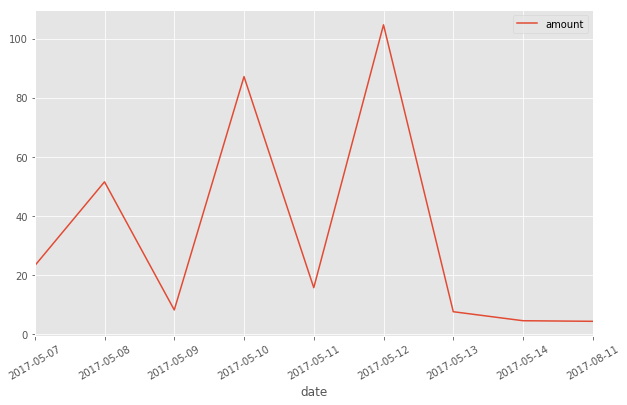

In [64]:
expenses.groupby("date")["amount"].sum().reset_index().plot(x="date", y="amount", rot=30, figsize=(10,6))
plt.show()